# Data organizers: proof of concept
This notebook has an overview of refactoring ArviZ plotting ideas. It only has proof of concept very rough implementations for now. One of the main goals is modularization, so a great deal of these ideas could be used by raw xarray.

It assumes you are already have some familiarity with ArviZ plotting.

In [1]:
import arviz as az
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
xr.set_options(display_expand_data=False);
#az.style.use("arviz-doc")

In [3]:
idata = az.load_arviz_data("rugby")
post = idata.posterior

## draft proposed extensions
I propose to create a class similar to facetgrid in xarray or in old seaborn.

:::{important}
For now this works on `DataArray`s only!! At this point in time, this is a proof of concept we can use to discuss API and ensure I am moving in the right direction. Once we are satisfied with this, I'll work on having this work
with `Dataset`s and iterables of `Dataset` (for plotting, dataset and inferencedata are equivalent in terms of plotting, we will never want to loop over groups to plot, only have info from multiple groups).
:::

In [4]:
from xrtist import PlotCollection

A `PlotCollection` should be initialized or reused for each plot. It can be initialized with `.grid` or `.wrap` classmethods. At init time it creates two attributes mostly: `.ds` and `.viz`.

* `.ds` is a dataset that stores the aesthetics mapping. It is used so that when we loop, we subset that dataset
  with the same `sel` used to subset the data and get the right aesthetics for that plot.
* `.viz` is used to store all the elements of the generated graph. At init time it only has the figure and axes.
  Then when plotting artists are also stored there.
  
The main method of `PlotCollection` is `.map`. `.map` loops over each of the data subsets defined in the `PlotCollection` and calls a plottting function. These plotting functions should take a dataarray of the data to plot and axes and return a single artist/glyph. It is possible to skip returning the artist, but it should be done in special cases only.

Let's see in in practice!

We start defining a function roughly equivalent to `plot_kde` but that follows the rules explained above.

In [5]:
def kde_artist(values, ax, **kwargs):
    grid, pdf = az.kde(np.array(values).flatten())
    return ax.plot(grid, pdf, **kwargs)[0]

### Base example: plot kdes for each of the 6 teams
We start with a basic example, plotting a kde for each of the teams. In this case, we only want to generate a subplot for each team, no aesthetics or anything else. We indicate this with `col=["team"]`. As we are using `.wrap` instead of row of 6 plots we get 2 rows of 3 plots. A `.grid` method is already available and something for plot_pair like plots will be added, be a `.pair` or `.matrix` classmethod or a `PlotMatrix` class with similar api.

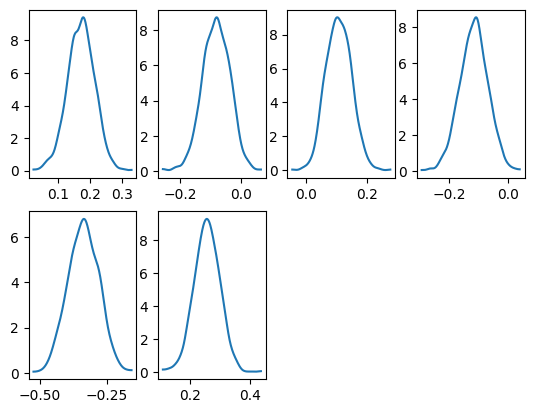

In [6]:
pc = PlotCollection.wrap(
    post["atts"], 
    cols=["team"], 
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist, "kde")

### Add aesthetics: plot kdes for each team in different subplots, overlaying the different chains with different colors.

We now use the `aes` argument to have each chain have a different color.

Note: not all plots will support all aesthetics.

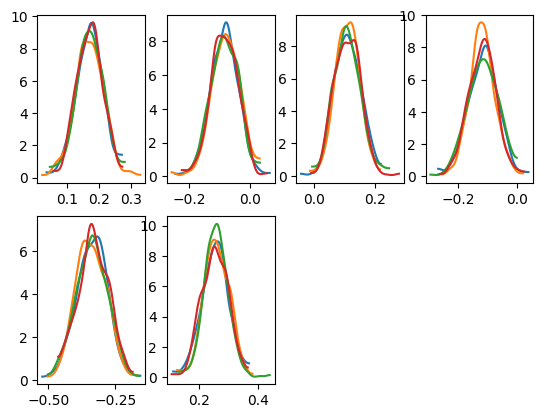

In [7]:
pc = PlotCollection.wrap(
    post["atts"], 
    cols=["team"], 
    aes={"color": ["chain"]}, 
    color=[f"C{i}" for i in range(4)],
    subplot_kws={"figsize": (12, 8)}
)
pc.viz
pc.map(kde_artist, "kde")

The figure (chart), axes (plot), row and col indexes (row, col) and generated artists are stored in an xarray dataset:

In [8]:
pc.viz

<xarray.Dataset>
Dimensions:  (team: 6, chain: 4)
Coordinates:
  * team     (team) object 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
  * chain    (chain) int64 0 1 2 3
Data variables:
    chart    object Figure(640x480)
    plot     (team) object AxesSubplot(0.125,0.53;0.168478x0.35) ... AxesSubp...
    row      (team) int64 0 0 0 0 1 1
    col      (team) int64 0 1 2 3 0 1
    kde      (chain, team) object Line2D(_child0) ... Line2D(_child3)

Same for aesthetics

In [9]:
pc.ds

<xarray.Dataset>
Dimensions:  (chain: 4)
Coordinates:
  * chain    (chain) int64 0 1 2 3
Data variables:
    color    (chain) <U2 'C0' 'C1' 'C2' 'C3'

### Multiple aesthetics for the same dimension

We can set multiple asethetics to the same dimension, and both will be updated in sync in all plots:

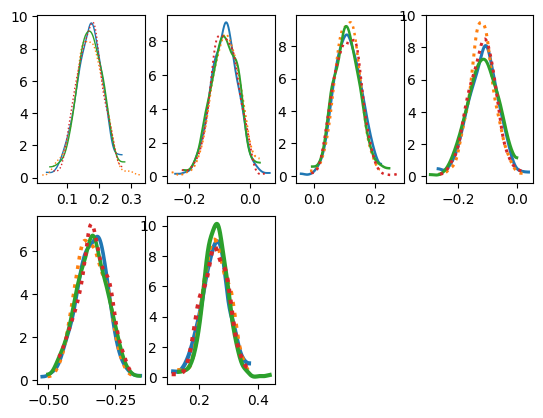

In [10]:
pc = PlotCollection.wrap(
    post["atts"], 
    cols=["team"], 
    aes={"color": ["chain"], "ls": ["chain"], "lw": ["team"]}, 
    color=[f"C{i}" for i in range(4)],
    ls=["-", ":"],
    lw=np.linspace(1, 3, 6),
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist)

### Easy access to all plots elements

And as we have stored all the plotting related data, including artists in the `.viz` attribute, we can select artists from the plot and modify them _with label based indexing_. Here we can make the line for the Italy team and 3rd chain have diamonds as markers after plotting, with size 10 and show markers only once every 50 datapoints.

Note: I'd also like to add an extra coordinate, `grid` or something of the sort, that can be used to select axes
by their position in the subplot grid.

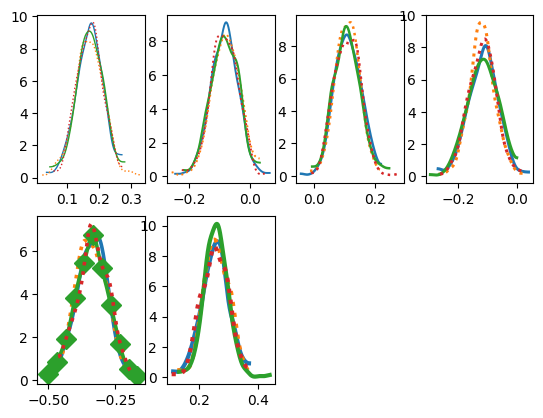

In [11]:
pc = PlotCollection.wrap(
    post["atts"], 
    cols=["team"], 
    aes={"color": ["chain"], "ls": ["chain"], "lw": ["team"]}, 
    color=[f"C{i}" for i in range(4)],
    ls=["-", ":"],
    lw=np.linspace(1, 3, 6),
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist, "kde")
pc.viz["kde"].sel(team="Italy", chain=2).item().set(marker="D", markersize=10, markevery=50);

We can change the layout of the plots and not need to change the subsetting and modification of the specific plot:

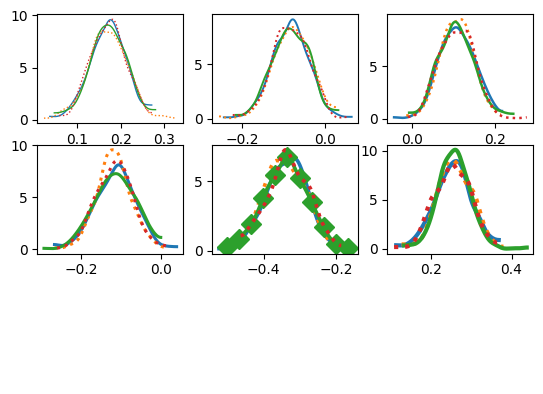

In [12]:
pc = PlotCollection.wrap(
    post["atts"], 
    cols=["team"], 
    col_wrap=3, # <-- change here!!
    aes={"color": ["chain"], "ls": ["chain"], "lw": ["team"]}, 
    color=[f"C{i}" for i in range(4)],
    ls=["-", ":"],
    lw=np.linspace(1, 3, 6),
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist, "kde")
pc.viz["kde"].sel(team="Italy", chain=2).item().set(marker="D", markersize=10, markevery=50);

And unlike xarray facetting, all asethetics and facetting variables take lists of dimensions, not single dimensions

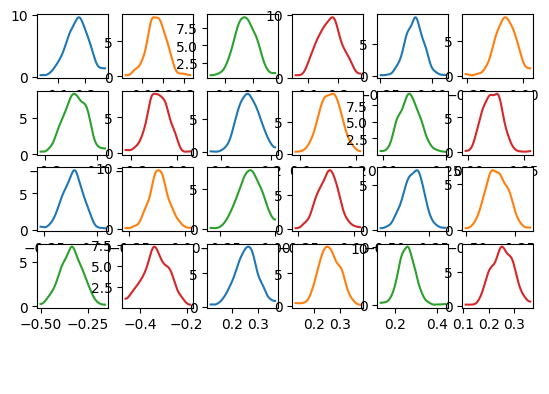

In [13]:
pc = PlotCollection.wrap(
    post["atts"], 
    cols=["team", "chain"],
    col_wrap=6,
    aes={"color": ["chain"]}, 
    color=[f"C{i}" for i in range(4)],
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist)

the `plot` variable contines to have both team and chain dimensions, that do not match the grid ones. This is ugly but it is being done to showcase this feature. Here we don't have too many dimensions, so it looks better to facet with row and col with one variable each. We can use the `.grid` classmethod:

In [14]:
pc.viz["plot"].where(pc.viz["col"] == 0, drop=True)

<xarray.DataArray 'plot' (team: 4, chain: 2)>
AxesSubplot(0.125,0.747241;0.110714x0.132759) ... AxesSubplot(0.125,0.26931;0...
Coordinates:
  * team     (team) object 'Wales' 'France' 'Scotland' 'Italy'
  * chain    (chain) int64 0 2

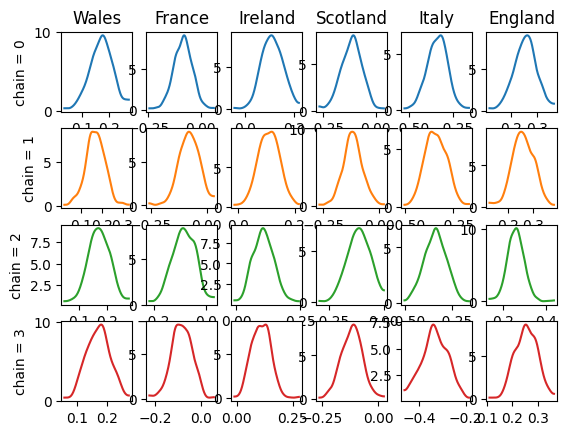

In [15]:
pc = PlotCollection.grid(
    post["atts"], 
    cols=["team"],
    rows=["chain"],
    aes={"color": ["chain"]}, 
    color=[f"C{i}" for i in range(4)],
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist)
for ax in pc.viz["plot"].sel(chain=0):
    ax.item().set_title(ax["team"].item())


for ax in pc.viz["plot"].isel(team=0):
    ax.item().set_ylabel(f"""chain = {ax["chain"].item()}""")

## Mimic existing ArviZ functions
### plot_posterior
We will now mimic `plot_posterior`. We start defining artist generating and returning funcitons for some more elements, like we did for kde. Functions are hidden in the rendering because they already take into account pre-processing which is explained in the next section.

In [16]:
def interval_artist(values, ax, **kwargs):
    if "preprocessed_data" in kwargs:
        pre_ds = kwargs.pop("preprocessed_data")
        interval = pre_ds["interval"]
    else:
        # not considering pre-processing would simplify the functions to these two lines
        int_func = kwargs.pop("int_func", az.hdi)
        interval = int_func(np.array(values).flatten())
    return ax.plot(interval, [0, 0], **kwargs)[0]

def point_artist(values, ax, **kwargs):
    if "preprocessed_data" in kwargs:
        pre_ds = kwargs.pop("preprocessed_data")
        point = pre_ds["point_estimate"].item()
    else:
        point_func = kwargs.pop("point_func", np.mean)
        point = point_func(np.array(values).flatten())
    return ax.plot(point, 0, **kwargs)[0]

def point_label_artist(values, ax, **kwargs):
    if "preprocessed_data" in kwargs:
        pre_ds = kwargs.pop("preprocessed_data")
        point = pre_ds["point_estimate"]
        point_label = kwargs.pop("point_label")
        pdf = pre_ds["kde"]
    else:
        point_func = kwargs.pop("point_func", np.mean)
        point_label = kwargs.pop("point_label", point_func.__name__)
        values = np.array(values).flatten()
        point = point_func(values)
        _, pdf = az.kde(values)

    top = np.max(pdf)
    
    return ax.text(point, .05 * top, f"{point:.2f} {point_label}", **kwargs)

def title_artist(values, ax, var_name, sel, isel, labeller_fun, **kwargs):
    label = labeller_fun(var_name, sel, isel)
    return ax.set_title(label, **kwargs)    

def remove_left_axis(values, ax, **kwargs):
    ax.get_yaxis().set_visible(False)
    ax.spines['left'].set_visible(False)

We now mimic plot_posterior (dataarray input only). Plot posterior takes an inferencedata and automatically generates the axes and plots everything. With `PlotCollection` this now becomes creating a plot collection (unless one is provided) and then calling `.map` multiple times to add all the elements to the plot: kde, hdi interval line, point estimate marker, point estimate text...

In [17]:
def plot_posterior(da, plot_collection=None, labeller=None):
    if plot_collection is None:
        plot_collection = PlotCollection.wrap(da, cols=[dim for dim in da.dims if dim not in {"chain", "draw"}])
    if labeller is None:
        labeller = az.labels.NoVarLabeller()
        
    labeller_fun = labeller.make_label_vert
    
    plot_collection.map(kde_artist, "kde")
    plot_collection.map(interval_artist, "interval", color="grey")    
    plot_collection.map(point_artist, "point_estimate", color="C0", ms="5", marker="o")
    plot_collection.map(point_label_artist, "point_label", color="C0", va="bottom", ha="center")
    plot_collection.map(remove_left_axis, store_artist=False)
    plot_collection.map(title_artist, "title", subset_info=True, labeller_fun=labeller_fun)
    return plot_collection

Here it can be seen how the usage is the same basically as our current API, but if we also expose the artist function, it will be much easier for users to create their own variations of `plot_posterior` or to extend it with their own artist functions.

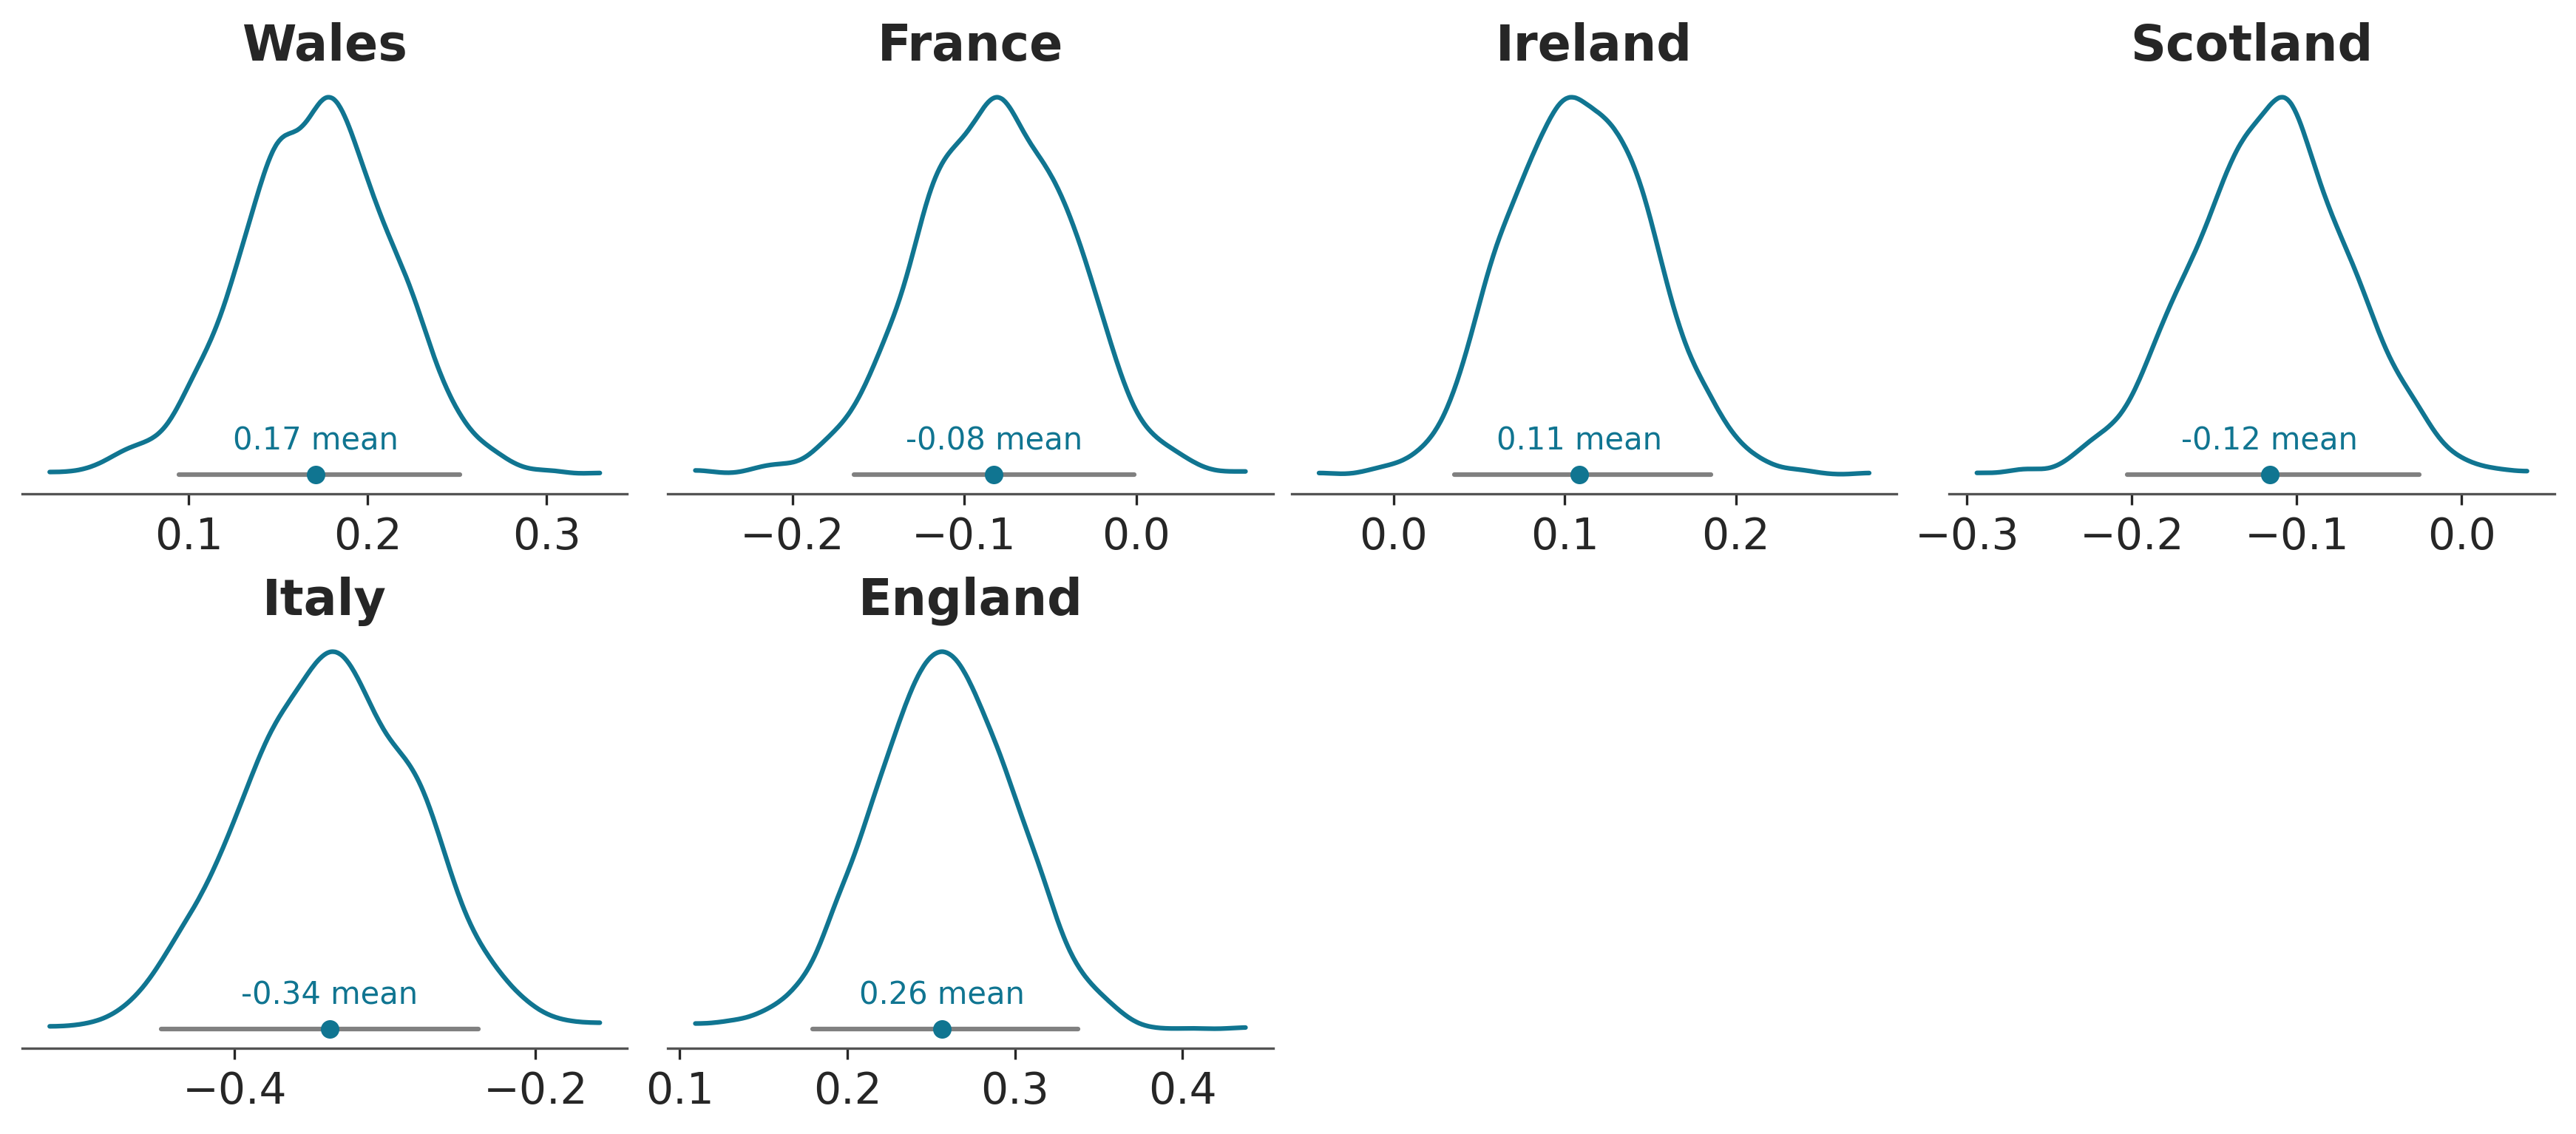

In [18]:
az.style.use("arviz-doc")
pc = plot_posterior(post["atts"])

Finally, we show how all the elements added to the plot have had their corresponding artists added to the `.viz` dataset.

In [19]:
pc.viz

<xarray.Dataset>
Dimensions:         (team: 6)
Coordinates:
  * team            (team) object 'Wales' 'France' ... 'Italy' 'England'
Data variables:
    chart           object Figure(3450x1500)
    plot            (team) object AxesSubplot(0.00362348,0.565778;0.237246x0....
    row             (team) int64 0 0 0 0 1 1
    col             (team) int64 0 1 2 3 0 1
    kde             (team) object Line2D(_child0) ... Line2D(_child0)
    interval        (team) object Line2D(_child1) ... Line2D(_child1)
    point_estimate  (team) object Line2D(_child2) ... Line2D(_child2)
    point_label     (team) object Text(0.17110852459382564, 0.470849748773512...
    title           (team) object Text(0.5, 1.0, 'Wales') ... Text(0.5, 1.0, ...

### Use preprocessed computations
Using these independent artist functions is convenient from a plotting perspective, but computationally it is much more demanding. We need to compute the point estimate for example in both the marker and the label artist, and in fact, to make the point estimate label look nice, we place it at 0.05 the height of the kde (with the marker at 0), so we also need to compute the kde twice (or 3 times if we want to use a similar trick for the hdi label).

The overall idea was (and is) to split data organization, processing and plotting into pieces as independent as possible. (keep in mind this is only a data organization proof of concept). Here we pre compute all the quantities we will need for plot posterior, and `.map` itself is the one that subsets this preprocessed data into subsets aligned with the raw data. Thus, if we use `preprocessed=True`, in each iteration the artist function gets both the raw data and the pre-processed data properly subsetted. That is, we now compute hdi, the point estimate and the kde only once.

Note: this avenue also has a lot of potential for further speed-ups. As computing the kde is no longer done _within_ the plotting loop (as it currently happens), we can parallelize the computation using one core per team for example. Then keep the looping for the plot only.

In [20]:
# example of an artist function that only works if using preprocessed=True in .map
def kde_artist_pre(values, ax, preprocessed_data, **kwargs):
    grid = preprocessed_data["grid"]
    pdf = preprocessed_data["kde"]
    return ax.plot(grid, pdf, **kwargs)[0]
    
def plot_posterior_pre(da, plot_collection=None, labeller=None):
    if plot_collection is None:
        plot_collection = PlotCollection.wrap(da, cols=[dim for dim in da.dims if dim not in {"chain", "draw"}])
        
    # pre compute all plot elements: hdi, mean and kde and add them to plot_collection
    pre_ds = xr.Dataset()
    pre_ds["interval"] = az.hdi(da)[da.name]
    pre_ds["point_estimate"] = da.mean(("chain", "draw"))
    grid, kde = az.wrap_xarray_ufunc(
        az.kde,
        post["atts"],
        ufunc_kwargs={"n_output": 2},
        func_kwargs={"out_shape": [(512,), (512,)], "grid_len": 512},
        output_core_dims=[["x_kde"], ["x_kde"]]
    )
    pre_ds["grid"] = grid
    pre_ds["kde"] = kde
    plot_collection.preprocessed_data = pre_ds
    
    if labeller is None:
        labeller = az.labels.BaseLabeller()
    labeller_fun = labeller.make_label_vert
    
    # add all drawings to the plot with no computation inside artist functions anymore, only plotting
    plot_collection.map(kde_artist_pre, "kde", preprocessed=True)
    plot_collection.map(interval_artist, "interval", preprocessed=True, color="grey")    
    plot_collection.map(point_artist, "point_estimate", preprocessed=True, color="C0", ms="5", marker="o")
    plot_collection.map(
        point_label_artist, "point_label", preprocessed=True, point_label="mean",
        color="C0", va="bottom", ha="center"
    )
    plot_collection.map(remove_left_axis, store_artist=False)
    plot_collection.map(title_artist, "title", subset_info=True, labeller_fun=labeller_fun)
    return plot_collection

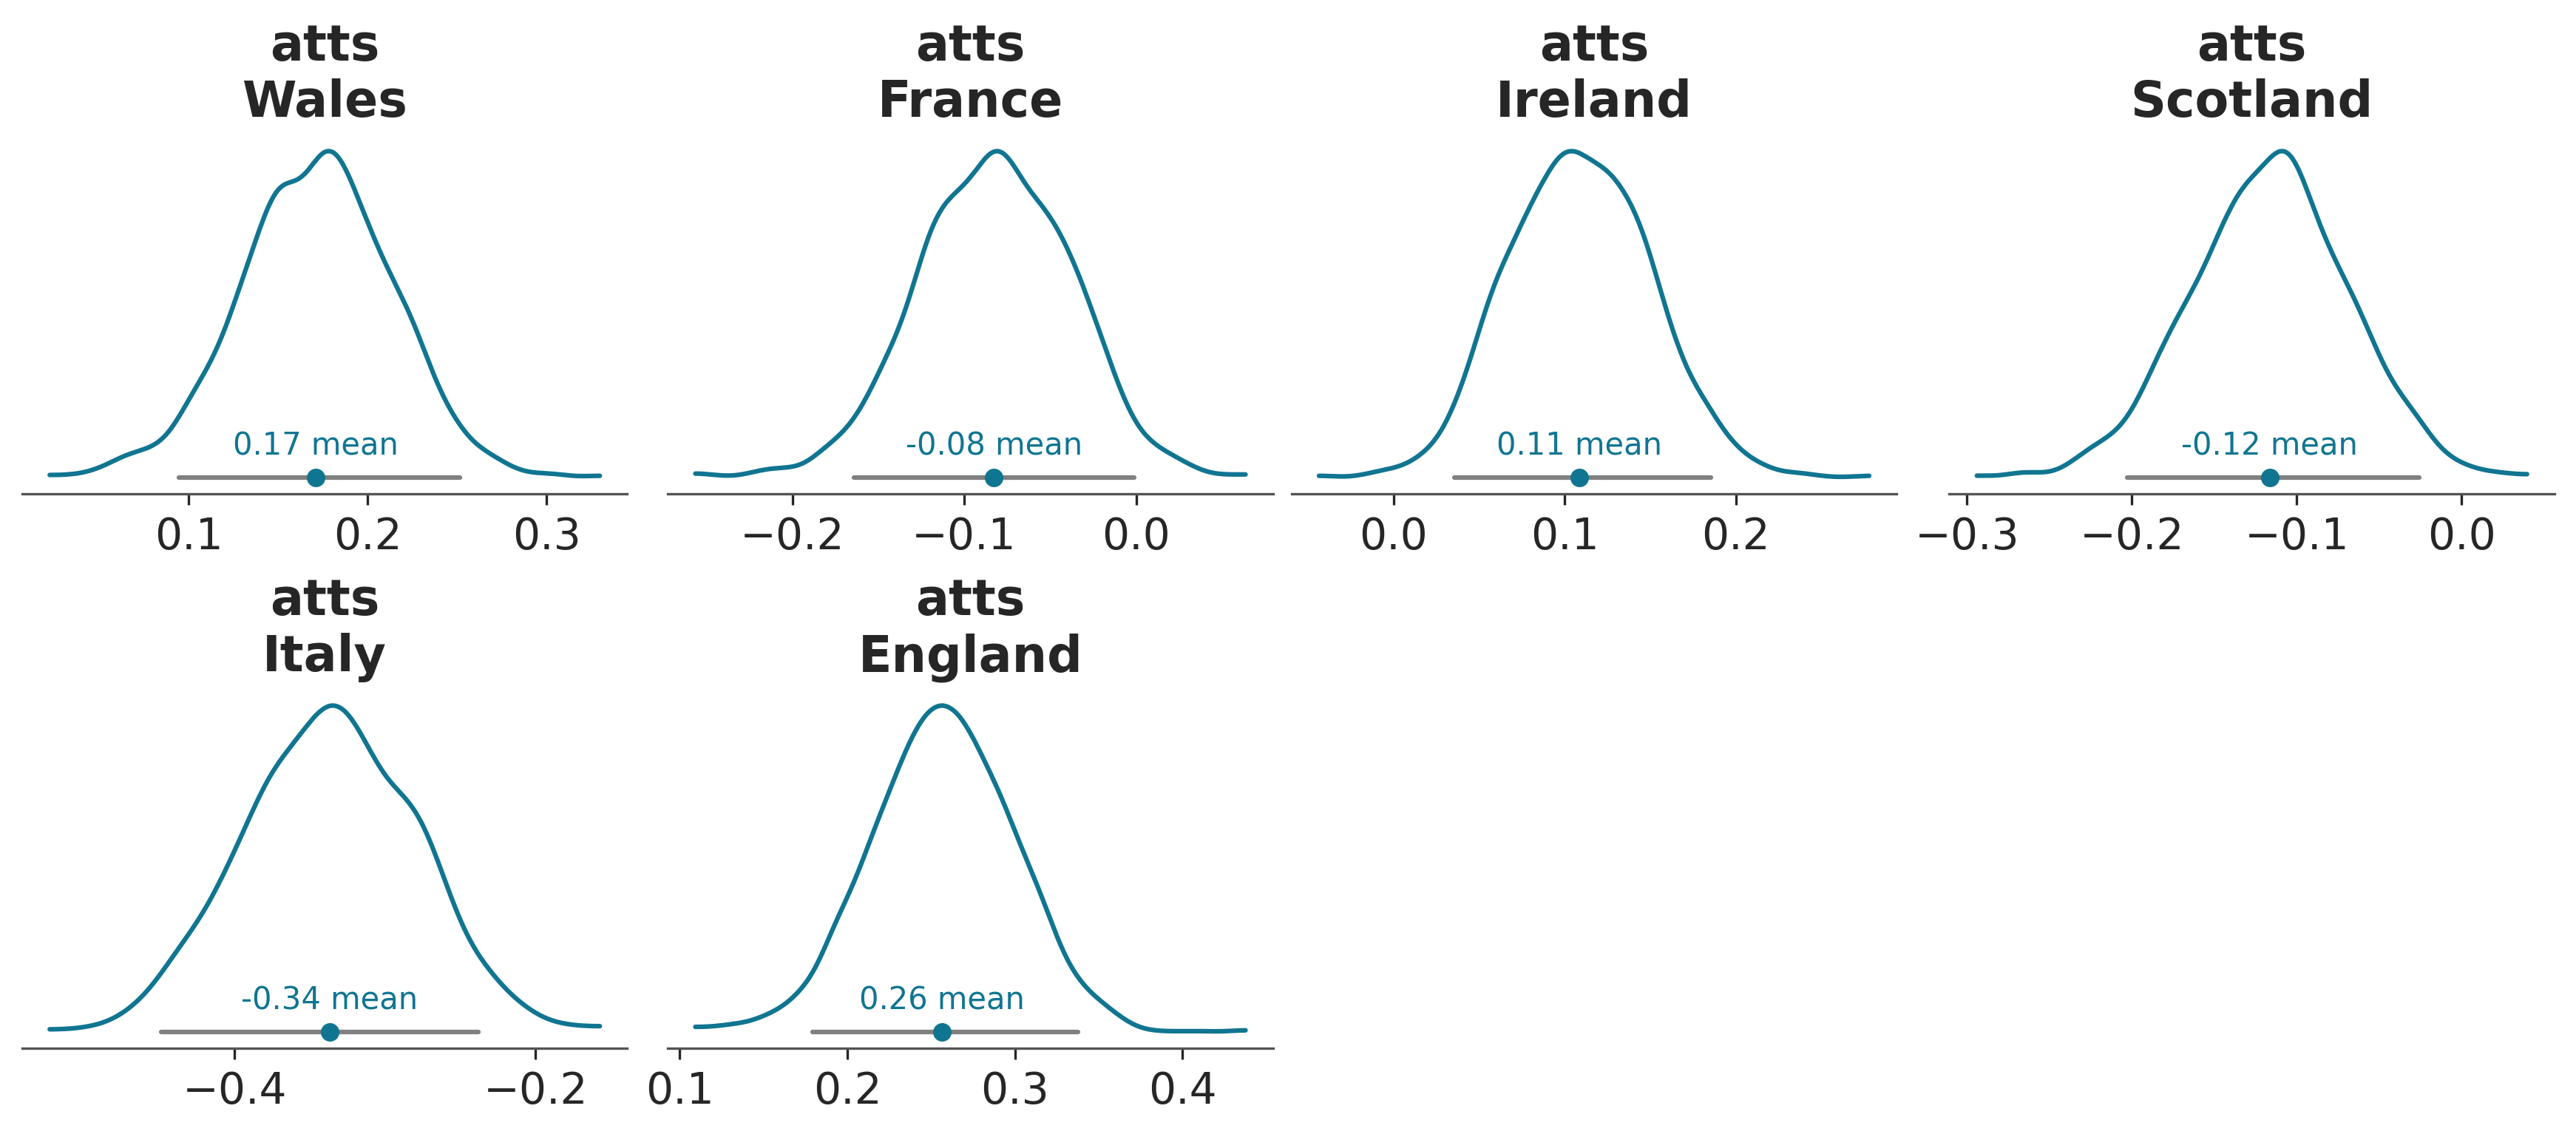

In [21]:
pc = plot_posterior_pre(post["atts"])

Pre-processed data is made available to the plot collection by setting the `.preprocessed_data` attribute which is also available later on in the returned plot collection. So potentially, all the preprocessed data could also be used in other plots (provided facetting and aesthetics are aligned!)

In [22]:
pc.preprocessed_data

<xarray.Dataset>
Dimensions:         (team: 6, hdi: 2, x_kde: 512)
Coordinates:
  * team            (team) object 'Wales' 'France' ... 'Italy' 'England'
  * hdi             (hdi) <U6 'lower' 'higher'
Dimensions without coordinates: x_kde
Data variables:
    interval        (team, hdi) float64 0.09464 0.2514 -0.1641 ... 0.1793 0.3376
    point_estimate  (team) float64 0.1711 -0.08273 0.1085 -0.1165 -0.337 0.2566
    grid            (team, x_kde) float64 0.02241 0.02301 ... 0.437 0.4376
    kde             (team, x_kde) float64 0.06984 0.07005 ... 0.04191 0.0422

### plot_trace
Even with very preliminary proof of concept like this, it is not excessively difficult to mimic more complicated facetting patterns like plot_trace:

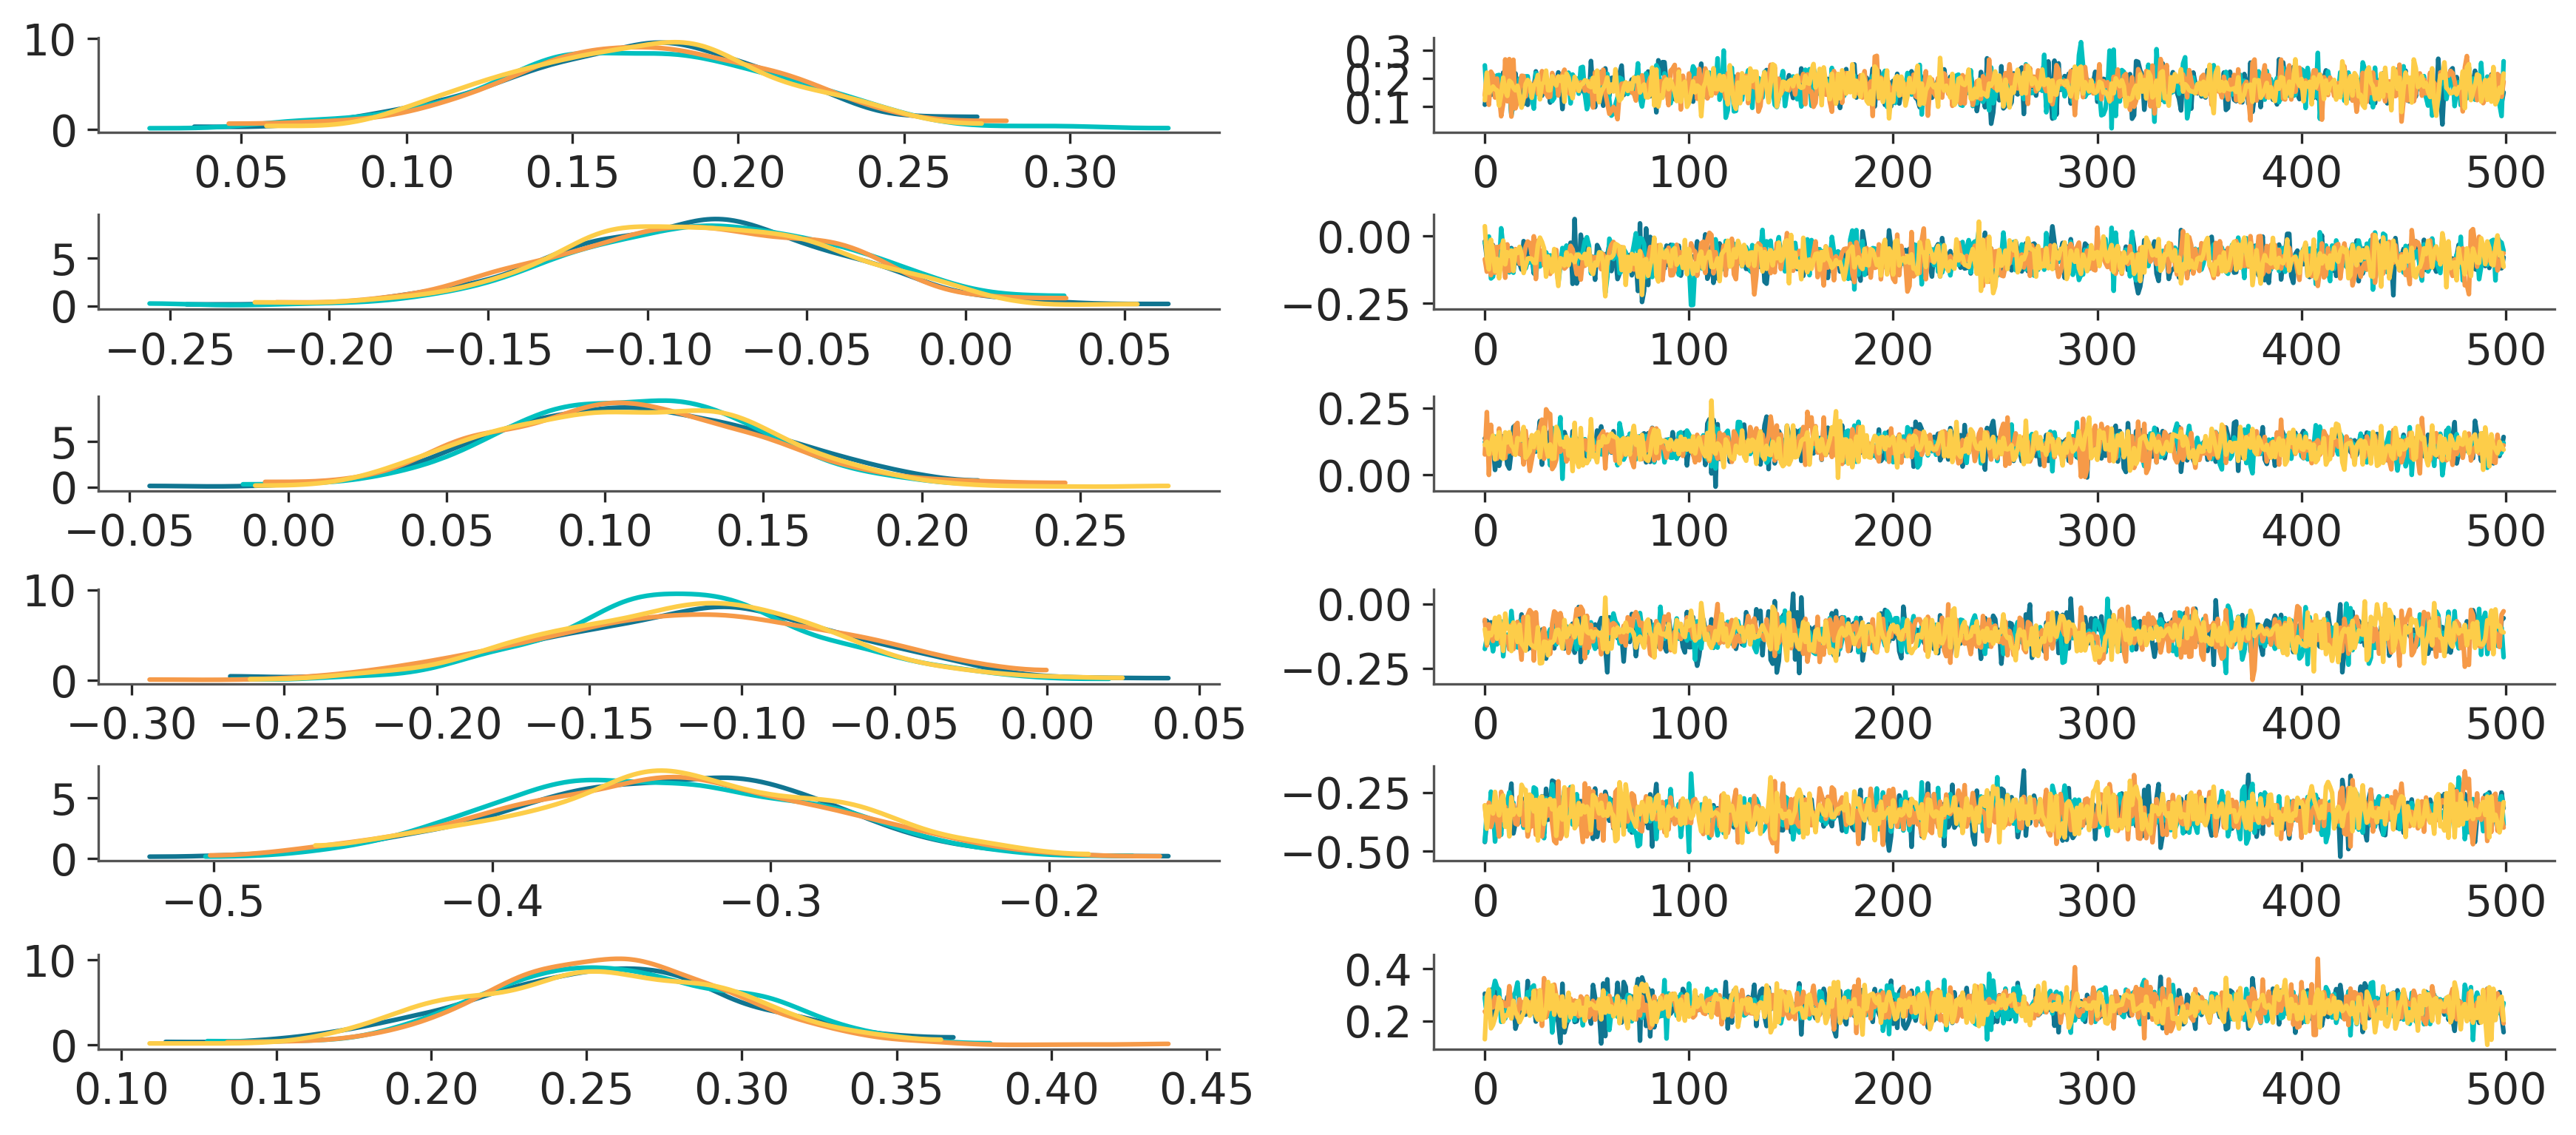

In [23]:
from copy import copy
pc = PlotCollection.grid(
    post["atts"].expand_dims(column=2), # add dummy dim for the extra 2 col facetting
    rows=["team"],
    cols=["column"],
    aes={"color": ["chain"]}, 
    color=[f"C{i}" for i in range(4)],
    subplot_kws={"figsize": (12, 8)}
)
pc_right = copy(pc)
pc_right.data = pc.data.isel(column=1)
pc_right.viz = pc.viz.isel(column=1)
pc_right.map(lambda values, ax, **kwargs: ax.plot(np.arange(len(values)), values, **kwargs)[0])
pc_left = copy(pc)
pc_left.data = pc.data.isel(column=0)
pc_left.viz = pc.viz.isel(column=0)
pc_left.map(kde_artist)

Legends will come soon.